In [1]:
import cv2
import torch, random, sklearn
import numpy as np
from torch import nn, optim
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from torch.nn import ModuleList, functional as F
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm_notebook
from tqdm import tqdm
import json, pickle

In [2]:
device = torch.device("cuda:0")

def preprocess(X, y):
    train_X, test_X, train_y, test_y = train_test_split(X, y)
    train_X, val_X, train_y, val_y = train_test_split(train_X, train_y)
    train_X = torch.from_numpy(train_X).to(device)
    val_X = torch.from_numpy(val_X).to(device)
    test_X = torch.from_numpy(test_X).to(device)

    train_y = torch.from_numpy(train_y).to(device)
    val_y = torch.from_numpy(val_y).to(device)
    test_y = torch.from_numpy(test_y).to(device)
    return train_X, val_X, test_X, train_y, val_y, test_y

In [2]:
try:
    with open("pos.dat", "rb") as f:
        X, y = pickle.load(f)
except FileNotFoundError:
    with open("ball_markup.json", "r") as f:
        data: dict = json.load(f)
    W, H = SIZE = (160, 90)
    X, y = [], []
    N = 2000

    cam = cv2.VideoCapture("game_1.mp4")
    for key, value in tqdm(random.sample(list(data.items()), N)):
        cam.set(cv2.CAP_PROP_POS_FRAMES, int(key))
        _, img = cam.read()
        h, w, c = img.shape
        img = cv2.resize(img, SIZE)
        X.append(cv2.split(img))
        v = [value['x']*W//w, value['y']*H//h]
        y.append(v)
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    
    cam.release()
    with open("pos.dat", "wb") as f:
        pickle.dump((X, y), f)
train_X, val_X, test_X, train_y, val_y, test_y = preprocess(X, y)


100%|██████████| 2000/2000 [01:40<00:00, 19.90it/s]


In [3]:
print(len(train_X), len(val_X), len(test_X), len(train_y), len(val_y), len(test_y))


1125 375 500 1125 375 500


In [3]:
K = 5
S = 2
P = 0
class NN(nn.Module):
    def __init__(self, channels, layers):
        super(NN, self).__init__()
        self.conv, self.dense = nn.ModuleList(), nn.ModuleList()
        self.ylim = 1000
        for i in range(1, len(channels)):
            self.conv.append(nn.Conv2d(in_channels=channels[i-1], out_channels=channels[i],
                                kernel_size=K, padding=P))
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 2), stride=S)
        for i in range(1, len(layers)):
            self.dense.append(nn.Linear(in_features=layers[i-1], out_features=layers[i]))
        for layer in self.conv+self.dense:
            nn.init.kaiming_normal_(layer.weight)
        self.loss_f = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters())
        self.to("cuda:0")
        

    def forward(self, x):
        if x.dim() == 3:
            x = x.unsqueeze(0)
        for layer in self.conv:
            x = layer(x)
            x = self.maxpool(x)
        x = torch.flatten(x, 1)
        for layer in self.dense[:-1]:
            x = layer(x)
            x = self.relu(x)
        x = self.dense[-1](x)
        return x
    def get_loss(self, x, y):
        predictions = self(x)
        loss = self.loss_f(predictions, y)
        return loss

    def my_train(self, train_x, train_y, val_x, val_y, epochs, intervals=20):
        min_epochs = epochs/10
        epochs = tqdm(range(epochs))
        min_val_loss = float('inf')
        losses = []
        for epoch in epochs:
            self.zero_grad()
            loss = self.get_loss(train_x, train_y)
            
            
            loss.backward()
            self.optimizer.step()
            losses.append(float(loss))
            if epoch >= min_epochs and epoch % intervals == 0:
                val_loss = self.get_loss(val_x, val_y)
                min_val_loss = min(min_val_loss, val_loss)
                if val_loss > min_val_loss * 1.05:
                    print(f"Stopped at Epoch {epoch}\nLoss: {val_loss}")
                    break
        plt.ylim((0, self.ylim))
        plt.plot(range(len(losses)), losses)
        plt.show()
class NN2(NN):
    def __init__(self, channels, layers):
        super().__init__(channels, layers)
        self.softmax = nn.Softmax(1)
        self.loss_f = nn.CrossEntropyLoss()
        self.ylim = 2
    def forward(self, x):
        x = super().forward(x)
        x = self.softmax(x)
        return x
    def ratio(self, x, y):
        predictions = self(x)
        correct = 0
        total = 0
        for p, l in zip(predictions, y):
            print(p, l)
            if (l[0] >= .5) == (p[0] >= .5):
                correct += 1
            total += 1  
        return correct/total

In [5]:
def get_output_size(w, k, p, s):
    return (w-k+2*p)//s + 1
w = get_output_size(160, 5, 0, 2)
h = get_output_size(90, 5, 0, 2)
w = get_output_size(w, 5, 0, 2)
h = get_output_size(h, 5, 0, 2)
print(w*h*7)

5180


In [42]:
net = NN([3, 5, 7], [4921, 800, 170, 40, 2])

In [43]:
net.my_train(train_X, train_y, val_X, val_y, 10000)


  7%|▋         | 692/10000 [00:05<01:08, 136.57it/s]


KeyboardInterrupt: 

In [11]:
print(net.get_loss(test_X, test_y))
for x, y in zip(test_X, test_y):
    r, g, b = x.cpu().numpy().astype(np.uint8)
    img = cv2.merge([r, g, b])
    h, w, c = img.shape
    img = cv2.resize(img, (1200, 900))
    c = net(x.unsqueeze(0))[0]
    c = (int(c[0]*1200/w), int(c[1]*900/h))
    img = cv2.circle(img, c, 10, (0, 0, 255))
    c = (int(y[0]*1200/w), int(y[1]*900/h))
    img = cv2.circle(img, c, 10, (0, 255, 0))

    cv2.imshow('i', img)
    if cv2.waitKey(0) == ord('a'): 
        cv2.destroyAllWindows()
        break
    cv2.destroyAllWindows()
    # break


tensor(143.4991, device='cuda:0', grad_fn=<MseLossBackward0>)


In [3]:
try:
    with open("exist.dat", "rb") as f:
        X, y = pickle.load(f)
except FileNotFoundError:
    with open("ball_markup.json", "r") as f:
        data: dict = json.load(f)
    W, H = SIZE = (160, 90)
    X, y = [], []
    N = 2000
    cam = cv2.VideoCapture("game_1.mp4")
    frame_count = int(cam.get(cv2.CAP_PROP_FRAME_COUNT))
    bar = tqdm(total=N)
    count = [0]*2
    l = list(range(frame_count))
    random.shuffle(l)
    for frame in l:
        index = int(str(frame) in data)
        if count[index] >= N // 2:
            continue
        bar.update()
        cam.set(cv2.CAP_PROP_POS_FRAMES, frame)
        _, img = cam.read()
        h, w, c = img.shape
        img = cv2.resize(img, SIZE)
        X.append(cv2.split(img))
        v = [0]*2
        v[index] += 1
        count[index] += 1
        y.append(v)
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    cam.release()
    with open("exist.dat", "wb") as f:
        pickle.dump((X, y), f)
train_X, val_X, test_X, train_y, val_y, test_y = preprocess(X, y)

100%|██████████| 2000/2000 [01:30<00:00, 21.78it/s]

In [4]:
net2 = NN2([3, 5, 7], [4921, 800, 170, 40, 2])


NameError: name 'NN2' is not defined

100%|██████████| 5000/5000 [14:47<00:00,  5.64it/s]


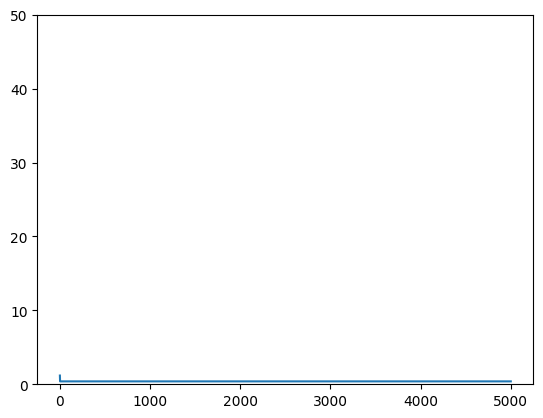

In [ ]:
net2.my_train(train_X, train_y, val_X, val_y, 5000)


In [ ]:
print(net2.ratio(test_X, test_y))

tensor([1., 0.], device='cuda:0', grad_fn=<UnbindBackward0>) tensor([1., 0.], device='cuda:0')
tensor([1., 0.], device='cuda:0', grad_fn=<UnbindBackward0>) tensor([1., 0.], device='cuda:0')
tensor([1., 0.], device='cuda:0', grad_fn=<UnbindBackward0>) tensor([1., 0.], device='cuda:0')
tensor([1., 0.], device='cuda:0', grad_fn=<UnbindBackward0>) tensor([1., 0.], device='cuda:0')
tensor([1., 0.], device='cuda:0', grad_fn=<UnbindBackward0>) tensor([1., 0.], device='cuda:0')
tensor([1., 0.], device='cuda:0', grad_fn=<UnbindBackward0>) tensor([1., 0.], device='cuda:0')
tensor([1., 0.], device='cuda:0', grad_fn=<UnbindBackward0>) tensor([1., 0.], device='cuda:0')
tensor([1., 0.], device='cuda:0', grad_fn=<UnbindBackward0>) tensor([1., 0.], device='cuda:0')
tensor([1., 0.], device='cuda:0', grad_fn=<UnbindBackward0>) tensor([1., 0.], device='cuda:0')
tensor([1., 0.], device='cuda:0', grad_fn=<UnbindBackward0>) tensor([1., 0.], device='cuda:0')
tensor([1., 0.], device='cuda:0', grad_fn=<UnbindB